# 06 - Random Forest

by [Alejandro Correa Bahnsen](albahnsen.com/) and [Jesus Solano](https://github.com/jesugome)

version 1.6, June 2020

## Part of the class [Advanced Methods in Data Analysis](https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass)


This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham))

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

# Predicting salary with a Random Forest

In [1]:
import pandas as pd
import numpy as np

# read in the data
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/hitters.csv'
hitters = pd.read_csv(url)

# remove rows with missing values
hitters.dropna(inplace=True)
hitters.head()

# encode categorical variables as integers
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]

# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

# define X and y
X = hitters[feature_cols]
y = (hitters.Salary > 425).astype(int)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [3]:
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.851567
std       0.049787
min       0.769231
25%       0.846154
50%       0.851852
75%       0.884615
max       0.923077
dtype: float64

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

In [7]:
# list of values to try for n_estimators
estimator_range = range(10, 500, 20)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

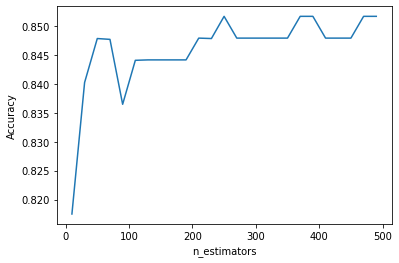

In [8]:
import matplotlib.pyplot as plt

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [9]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

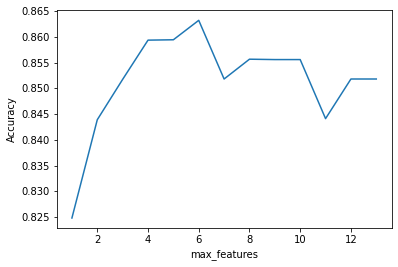

In [10]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

### Fitting a Random Forest with the best parameters

In [11]:
# max_features=6 is best and n_estimators=200 is sufficiently large
clf = RandomForestClassifier(n_estimators=200, max_features=6, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(max_features=6, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [12]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
8,Division,0.006081
7,League,0.008834
12,NewLeague,0.009709
11,Errors,0.032638
10,Assists,0.040503
2,HmRun,0.047118
9,PutOuts,0.051506
0,AtBat,0.078822
3,Runs,0.080185
5,Walks,0.082160


## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict